In [5]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import json 
from sklearn.metrics import roc_curve

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
INPUT_PATH = "../../data/lda/manual_ratings_topic19_merged.json"

In [7]:
ratings_dict = json.load(open(INPUT_PATH))
ratings = ratings_dict["ratings_merged"]
probabilities = ratings_dict["probabilities"]

In [8]:
X = np.array(probabilities).reshape(-1, 1)
y = np.array(ratings)

Text(0, 0.5, 'Decision')

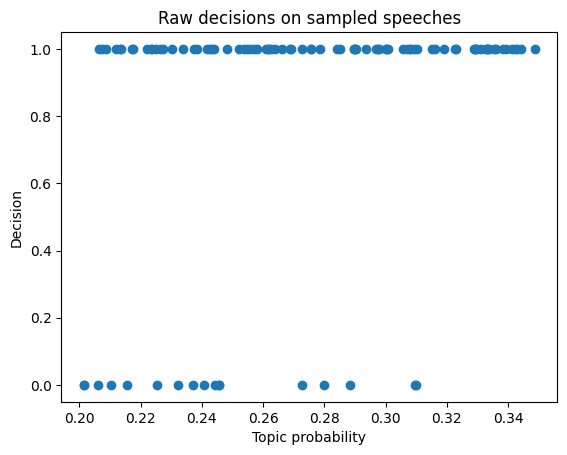

In [18]:
plt.plot(X, y, 'o')
plt.title("Raw decisions on sampled speeches")
plt.xlabel("Topic probability")
plt.ylabel("Decision")

Optimal threshold using ROC curve: 0.2481


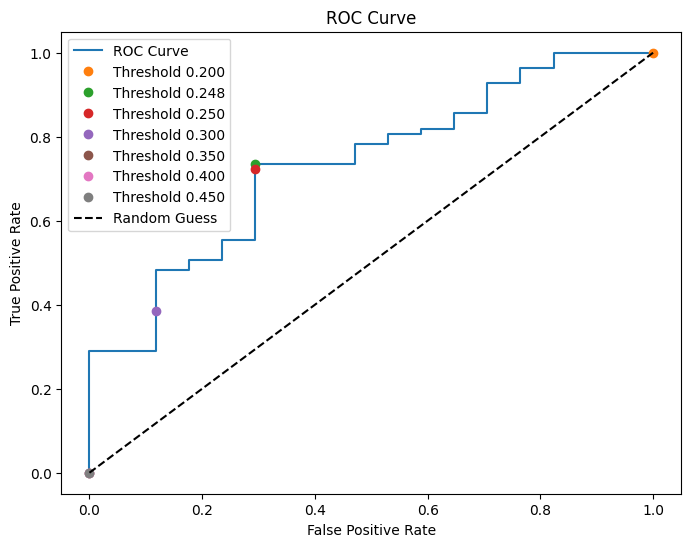

In [23]:
fpr, tpr, thresholds = roc_curve(y, X)
best = np.argmax(tpr - fpr)
threshold = thresholds[best]
print(f"Optimal threshold using ROC curve: {threshold:.4f}")
# plot ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y, X)
plt.plot(fpr, tpr, label='ROC Curve')
for thresh in sorted([0.2, threshold, 0.25, 0.3, 0.35, 0.4, 0.45]):
    pred = (xs >= thresh).astype(int)
    fpr = np.sum((pred == 1) & (ys == 0)) / np.sum(ys == 0)
    tpr = np.sum((pred == 1) & (ys == 1)) / np.sum(ys == 1)
    plt.plot(fpr, tpr, 'o', label=f'Threshold {thresh:.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

=> we chose threshold 0.25 because it attains best relationship of true positive and false positive rate